# Instruction

**Run each cell one by one**

# Load data


In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pprint, pickle
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id_1_train="1GFFtOkPJskSjhA7-Klfj33fF5eVWa5sE"
id_1_evaluation="1G7cd67MlLEBn-OoY612T08yBoRoGyXyd"


id_2_train="1AP5V-adbxm-bdOuB-7EtgegqzqtlldxZ"
id_2_evaluation="1-XoFS7lPF9DQSO4ItK_KtorUaLFmA4Pn"

id_3_train="1RFuUrqJPqBWycC_j1b2Vy1DgBr1yQbPG"
id_3_evaluation="1fPSYHnTi5ORcI7QgXjIduAYOYZsoE9tI"

id_4_train="1jovz85ALrSRBZgLNUeeoihSJkEYJT3ZH"
id_4_evaluation="1e6C3vn7sPV-LO-Q1EbLTHvlcT7oqhJ99"


id_5_train="17wrRD332sGeRob6W36MNkQmj9Kc6u5lG"
id_5_evaluation="1JUc3flvygXmhdTL-kM_9pvh25pKfpvNy"

id_6_train="1vROntA0I75Gq85VXa9jwukl-IXxEOCCb"
id_6_evaluation="1pYnce5N2KxxNmFM2sgfxldLpaKgclEiY"

id_7_train="1_qvjVphyrE311iInuVDhhWWWN3BC4-sm"
id_7_evaluation="18V-Tp3Kny9aYz8rxSFsRQrYDtstVF75d"


id_8_train="1Cpi6yNpnMX5oCClCClv7Lcgg2RvxspUF"
id_8_evaluation="13cz0_VMYI0-u2LlEhmy61mGuzmjbmP1B"

id_9_train="1o0gyOZrYsyw68GFhpKFuwoFRn4pVwb7Q"
id_9_evaluation="1KW0_TzquGXygyBksatKEvevm6NYwddEA"



def load(id_train,id_evaluation,subject):
  downloaded = drive.CreateFile({'id':id_train}) 
  downloaded.GetContentFile('A0'+str(subject)+'T.mat')
  downloaded = drive.CreateFile({'id':id_evaluation}) 
  downloaded.GetContentFile('A0'+str(subject)+'E.mat')

load(id_1_train,id_1_evaluation,1)
load(id_2_train,id_2_evaluation,2)
load(id_3_train,id_3_evaluation,3)

load(id_4_train,id_4_evaluation,4)
load(id_5_train,id_5_evaluation,5)
load(id_6_train,id_6_evaluation,6)

load(id_7_train,id_7_evaluation,7)
load(id_8_train,id_8_evaluation,8)
load(id_9_train,id_9_evaluation,9)



# Package

In [2]:
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.function import Function
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.decomposition import PCA
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler


# Load data

In [3]:
def load_all_data (crossValidation, data_path): 

    big_X_train, big_y_train, big_X_test, big_y_test = [None]*9, [None]*9, [None]*9, [None]*9
    for subject in range (0,9):
        path = data_path+'s' + str(subject+1) + '/'
        big_X_train[subject], big_y_train[subject] = get_data(subject+1, True ,path)
        big_X_test[subject], big_y_test[subject] = get_data(subject+1, False ,path)
    
    return big_X_train, big_y_train, big_X_test, big_y_test

def get_data_2(subject,training,path, highpass = False):
	'''	Loads the dataset 2a of the BCI Competition IV
	available on http://bnci-horizon-2020.eu/database/data-sets

	Keyword arguments:
	subject -- number of subject in [1, .. ,9]
	training -- if True, load training data
				if False, load testing data
	
	Return:	data_return 	numpy matrix 	size = NO_valid_trial x 22 x 1750
			class_return 	numpy matrix 	size = NO_valid_trial
	'''
	NO_channels = 22
	NO_tests = 6*48 	
	Window_Length = 7*250 

	class_return = np.zeros(NO_tests)
	data_return = np.zeros((NO_tests,NO_channels,Window_Length))

	NO_valid_trial = 0
	if training:
		a = sio.loadmat(path+'A0'+str(subject)+'T.mat')
	else:
		a = sio.loadmat(path+'A0'+str(subject)+'E.mat')
	a_data = a['data']
	for ii in range(0,a_data.size):
		a_data1 = a_data[0,ii]
		a_data2= [a_data1[0,0]]
		a_data3= a_data2[0]
		a_X 		= a_data3[0]
		a_trial 	= a_data3[1]
		a_y 		= a_data3[2]
		a_fs 		= a_data3[3]
		a_classes 	= a_data3[4]
		a_artifacts = a_data3[5]
		a_gender 	= a_data3[6]
		a_age 		= a_data3[7]

		for trial in range(0,a_trial.size):
			if(a_artifacts[trial]==0):
				data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
				class_return[NO_valid_trial] = int(a_y[trial])
				NO_valid_trial +=1

	return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

def prepare_features(path,subject,crossValidation=False):
    fs = 250 
    # t1 = int(1.5*fs)
    t1 = int(2*fs)

    t2 = int(6*fs)
    T = t2-t1
    X_train, y_train = get_data_2(subject+1,True,path)
    # X_train, y_train,train_artifact = get_data_2(subject+1,True,path)

    if crossValidation:
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, test_size=0.2, random_state=0)
    else:
        X_test, y_test = get_data_2(subject+1,False,path)

    # prepare training data 	
    N_tr,N_ch,_ =X_train.shape 
    X_train = X_train[:,:,t1:t2].reshape(N_tr,1,N_ch,T)
    y_train_onehot = (y_train-1).astype(int)
    y_train_onehot = to_categorical(y_train_onehot)
    # prepare testing data 
    N_test,N_ch,_ =X_test.shape 
    X_test = X_test[:,:,t1:t2].reshape(N_test,1,N_ch,T)
    y_test_onehot = (y_test-1).astype(int)
    y_test_onehot = to_categorical(y_test_onehot)	

    return X_train,y_train,y_train_onehot,X_test,y_test,y_test_onehot

# Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch

hyperparameter_se=10
kersize=5



class EEGNet(nn.Module):
    def __init__(self, classes_num):
        super(EEGNet, self).__init__()
        self.numC=classes_num

        self.drop_out = 0.2
        
        self.block_1 = nn.Sequential(
            # Pads the input tensor boundaries with zero
            # left, right, up, bottom
            nn.ZeroPad2d((15, 16, 0, 0)),
            nn.Conv2d(
                in_channels=1,          # input shape (1, C, T)
                out_channels=8,         # num_filters
                kernel_size=(1, 32),    # filter size
                bias=False
            ),                          # output shape (8, C, T)
            nn.BatchNorm2d(8)           # output shape (8, C, T)
        )
        
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,          # input shape (8, C, T)
                out_channels=16,        # num_filters
                kernel_size=(self.numC, 1),    # filter size
                groups=8,
                bias=False
            ),                          # output shape (16, 1, T)
            nn.BatchNorm2d(16),         # output shape (16, 1, T)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),       # output shape (16, 1, T//4)
            nn.Dropout(self.drop_out)   # output shape (16, 1, T//4)
        )
        
        self.block_3 = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
               in_channels=16,          # input shape (16, 1, T//4)
               out_channels=16,         # num_filters
               kernel_size=(1, 16),     # filter size
               groups=16,
               bias=False
            ),                          # output shape (16, 1, T//4)
            nn.Conv2d(
                in_channels=16,         # input shape (16, 1, T//4)
                out_channels=16,        # num_filters
                kernel_size=(1, 1),     # filter size
                bias=False
            ),                          # output shape (16, 1, T//4)
            nn.BatchNorm2d(16),         # output shape (16, 1, T//4)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),       # output shape (16, 1, T//32)
            nn.Dropout(self.drop_out)
        )

    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = x.view(x.size(0), -1)
        return x 


    def get_embedding(self, x):
        return self.forward(x)




class RelationNetwork(nn.Module):
    """docstring for RelationNetwork"""
    def __init__(self,input_size,hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(30,16,kernel_size=(1,2),padding=1),
                        nn.BatchNorm2d(16, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,16,kernel_size=(1,2),padding=1),
                        nn.BatchNorm2d(16, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.fc1 = nn.Linear(64,hidden_size)
        self.fc2 = nn.Linear(hidden_size,1)

    def forward(self,x):
        x=x.view(-1,30,1,16)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out



class Time_net(nn.Module):
  # def __init__(self, feature_dim,hidden_dim, n_layers):
  def __init__(self,train_num):

        super(Time_net, self).__init__()
        # self.n_layers = n_layers
        # self.hidden_dim = hidden_dim
        # self.lstm = nn.RNN(feature_dim, hidden_dim, n_layers)
        self.pad = nn.ZeroPad2d((0, 0, kersize-1, 0))
        # self.series_decoding= nn.Conv2d(1,1,kernel_size=(15,1),padding="same")
        self.series_decoding= nn.Conv2d(1,1,kernel_size=(kersize,1))

  def forward(self, x):
        x = x.view(1,x.size(0),x.size(1))
        x = self.pad(x)

        x =  self.series_decoding(x)
        # # print(x.shape)
        # lstm_out, hidden = self.lstm(x)
        x = x.view(x.size(1),-1)
        # return lstm_out
        return x


# class RelationNetwork(nn.Module):
#     """docstring for RelationNetwork"""
#     def __init__(self,hidden_dim,middle_dim):
#         super(RelationNetwork, self).__init__()
#         self.layer1 = nn.Linear(hidden_dim,middle_dim)
#         self.layer2 = nn.Linear(middle_dim,1)

#     def forward(self,x):
#         out = F.relu(self.layer1(x))
#         out = torch.sigmoid(self.layer2(out))
#         return out


# Data generator

In [5]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader,Dataset
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import Sampler

class BCI_task(object):

    def __init__(self, feature_list,label,train_num,test_num,settype):

        self.train_num = train_num
        self.test_num = test_num
        if settype=="test":
          index1=np.where(label == 0)[0]
          index2=np.where(label == 1)[0]
          index3=np.where(label == 2)[0]
          index4=np.where(label == 3)[0]

          choice1=np.random.choice(index1,train_num,replace=False)
          choice2=np.random.choice(index2,train_num,replace=False)
          choice3=np.random.choice(index3,train_num,replace=False)
          choice4=np.random.choice(index4,train_num,replace=False)


          choice_total=np.sort(np.hstack((choice1,choice2,choice3,choice4)))
          self.training_feature = feature_list[choice_total]
          self.train_labels= label[choice_total]

          self.testing_feature= np.delete(feature_list, choice_total,0)
          self.test_labels=np.delete(label, choice_total)

        else:
          index1=np.where(label == 0)[0]
          index2=np.where(label == 1)[0]
          index3=np.where(label == 2)[0]
          index4=np.where(label == 3)[0]

          choice1=np.random.choice(index1,train_num+test_num,replace=False)
          choice2=np.random.choice(index2,train_num+test_num,replace=False)
          choice3=np.random.choice(index3,train_num+test_num,replace=False)
          choice4=np.random.choice(index4,train_num+test_num,replace=False)


          train_choice=np.sort(np.hstack((choice1[:train_num],choice2[:train_num],choice3[:train_num],choice4[:train_num])))
          test_choice=np.hstack((choice1[train_num:],choice2[train_num:],choice3[train_num:],choice4[train_num:]))

    

          self.training_feature = feature_list[train_choice]
          self.train_labels= label[train_choice]



          self.testing_feature = feature_list[test_choice]
          self.test_labels =label[test_choice]



class FewShotDataset(Dataset):

    def __init__(self, task, split='train'):
        self.task = task
        self.split = split
        self.feature = self.task.training_feature if self.split == 'train' else self.task.testing_feature
        self.labels = self.task.train_labels if self.split == 'train' else self.task.test_labels

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        raise NotImplementedError("This is an abstract class. Subclass this class for your particular dataset.")


class BCI_DATA(FewShotDataset):
    def __init__(self, *args, **kwargs):
        super(BCI_DATA, self).__init__(*args, **kwargs)

    def __getitem__(self, idx):
        feature = self.feature[idx]
        label = self.labels[idx]
        return feature.astype(np.float32), label


def get_data_loader(task, split='train',shuffle=False):
    dataset = BCI_DATA(task,split=split)
    number = len(task.training_feature) if split == 'train' else len(task.testing_feature)
    loader = DataLoader(dataset, batch_size=number,shuffle=shuffle)
    return loader

# Weight initializer

In [6]:
import math

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        n = m.weight.size(1)
        m.weight.data.normal_(0, 0.01)
        m.bias.data = torch.ones(m.bias.data.size())

# Hyperparameter

In [7]:
TRAIN_NUM=hyperparameter_se
TEST_NUM=hyperparameter_se
LEARNING_RATE=0.001

EPSIODE_NUM=15000


FEATURE_DIM=240
RELATION_DIM=240
n_layers=1
MIDDLE_DIM=16

In [8]:
dic=[]


for x in range(9):
  temp=[]
  x_train,y_train,y_train_onehot,x_test,y_test,y_test_onehot = prepare_features('',x,False)
  xxxtest=np.vstack((x_train,x_test))
  yyytest=np.hstack((y_train,y_test))-1
  temp.append(xxxtest)
  temp.append(yyytest)

  dic.append(temp)


#Main

In [9]:
def main(Subject_number):

  GPU=99
  print("init neural networks")


  torch.manual_seed(GPU)
  torch.cuda.manual_seed(GPU)
  torch.cuda.manual_seed_all(GPU)

  np.random.seed(GPU)
  random.seed(GPU)

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  feature_encoder = EEGNet(classes_num=22)
  LSTM_encoder=Time_net(TRAIN_NUM)

  GPU=0

  relation_network = RelationNetwork(FEATURE_DIM,MIDDLE_DIM)

  feature_encoder.apply(weights_init)
  relation_network.apply(weights_init)

  feature_encoder.cuda(GPU)
  LSTM_encoder_optim = torch.optim.Adam(LSTM_encoder.parameters(),lr=LEARNING_RATE)
  LSTM_encoder.cuda(GPU)

  relation_network.cuda(GPU)

  full_subjectnum=[0,1,2,3,4,5,6,7,8]
  full_subjectnum.remove(Subject_number)


  total_losss=[]
  feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=LEARNING_RATE)
  relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=LEARNING_RATE)




  train_____=[]
  test______=[]
  testacce=[]


  for episode in range(EPSIODE_NUM):
    select_subject=np.random.choice(full_subjectnum, 1)[0]
    x_train,y_train = dic[select_subject][0],dic[select_subject][1]

    bci_task=BCI_task(x_train,y_train,train_num=TRAIN_NUM,test_num=TEST_NUM,settype='train')
    sample_dataloader = get_data_loader(bci_task,split="train",shuffle=False)
    batch_dataloader = get_data_loader(bci_task,split="test",shuffle=False)

    samples,sample_labels = sample_dataloader.__iter__().next()
    batches,batch_labels = batch_dataloader.__iter__().next()

    sample_dataloader = get_data_loader(bci_task,split="train",shuffle=False)
    batch_dataloader = get_data_loader(bci_task,split="test",shuffle=False)

    samples,sample_labels = sample_dataloader.__iter__().next()
    batches,batch_labels = batch_dataloader.__iter__().next()

    sample_labels=sample_labels.type(torch.int32).cuda(GPU)
    sample_features = feature_encoder(Variable(samples).cuda(GPU)) # 10x16*1*4
    sample_features=LSTM_encoder(sample_features)

    nrow = torch.unique(sample_labels).size(0)
    out = torch.zeros((nrow, sample_features.size(1)), dtype=sample_features.dtype).cuda(GPU)
    out.index_add_(0, sample_labels, sample_features)
    sample_features=out    
    batch_features = feature_encoder(Variable(batches).cuda(GPU))



    NUMEUSED=TEST_NUM*4
    sample_features_ext = sample_features.unsqueeze(0).repeat(NUMEUSED,1,1)
    batch_features_ext = batch_features.unsqueeze(0).repeat(sample_features.size(0),1,1)
    batch_features_ext = torch.transpose(batch_features_ext,0,1)



    relation_pairs = torch.cat((sample_features_ext,batch_features_ext),2).view(-1,batch_features_ext.size()[2]*2)
    relations = relation_network(relation_pairs)
    relations = relations.view(NUMEUSED,-1)
    mse = nn.MSELoss(reduction='mean').cuda(GPU)


    one_hot_labels =F.one_hot(batch_labels.to(torch.int64), num_classes=4).float().cuda(GPU)

    loss = mse(relations,one_hot_labels)

    feature_encoder.zero_grad()
    relation_network.zero_grad()
    LSTM_encoder.zero_grad()


    loss.backward()


    torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(),0.5)
    torch.nn.utils.clip_grad_norm_(LSTM_encoder.parameters(),0.5)
    torch.nn.utils.clip_grad_norm_(relation_network.parameters(),0.5)

    feature_encoder_optim.step()
    LSTM_encoder_optim.step()
    relation_network_optim.step()


    total_losss.append(loss.item())


    if (episode+1)%60 == 0:
        # print("episode:",episode+1,"loss",np.mean(total_losss))
        train_____.append(np.mean(total_losss))

        total_losss=[]

        x_test,y_test = dic[Subject_number][0],dic[Subject_number][1]
        total_rewards = 0
        bci_task=BCI_task(x_test,y_test,train_num=TRAIN_NUM,test_num=TEST_NUM,settype='test')
      

        sample_dataloader = get_data_loader(bci_task,split="train",shuffle=False)
        batch_dataloader = get_data_loader(bci_task,split="test",shuffle=False)

        samples,sample_labels = sample_dataloader.__iter__().next()
        batches,batch_labels = batch_dataloader.__iter__().next()

        sample_labels=sample_labels.type(torch.int32).cuda(GPU)
        sample_features = feature_encoder(Variable(samples).cuda(GPU))
        sample_features=LSTM_encoder(sample_features)

        nrow = torch.unique(sample_labels).size(0)
        out = torch.zeros((nrow, sample_features.size(1)), dtype=sample_features.dtype).cuda(GPU)
        out.index_add_(0, sample_labels, sample_features)
        sample_features=out    
        batch_features = feature_encoder(Variable(batches).cuda(GPU))
        

        sample_features_ext = sample_features.unsqueeze(0).repeat(len(bci_task.testing_feature),1,1)
        batch_features_ext = batch_features.unsqueeze(0).repeat(sample_features.size(0),1,1)
        batch_features_ext = torch.transpose(batch_features_ext,0,1)

        
        relation_pairs = torch.cat((sample_features_ext,batch_features_ext),2).view(-1,batch_features_ext.size()[2]*2)
        relations = relation_network(relation_pairs)
        relations = relations.view(len(bci_task.testing_feature),-1)

        one_hot_labels =F.one_hot(batch_labels.to(torch.int64), num_classes=4).float().cuda(GPU)
        testing_loss = mse(relations,one_hot_labels)
        test______.append(testing_loss.item())

  return train_____,test______





In [14]:
Subject_number=0
train_____,test______=main(Subject_number)


In [11]:
print(train_____)
print(test______)

[0.2752775698900223, 0.18801967029770214, 0.18771333197752635, 0.1876420112947623, 0.18761154189705848, 0.18741396938761076, 0.1872774211068948, 0.1865532341102759, 0.1852355954547723, 0.18294919033845267, 0.1823052612443765, 0.18179713239272435, 0.17950537527600924, 0.17694654787580172, 0.17670400887727739, 0.17433295994997025, 0.17269043028354644, 0.1677690121034781, 0.16534939830501874, 0.16451453790068626, 0.1592772160967191, 0.15845521576702595, 0.15480504098037878, 0.1542469968398412, 0.15219199359416963, 0.15133967995643616, 0.15156382334729035, 0.14415115950008234, 0.15479148750503857, 0.14760005498925846, 0.14841977891822655, 0.1469059350589911, 0.14447626248002052, 0.14428878525892894, 0.1469755734006564, 0.1420059251288573, 0.14653044690688452, 0.141376210624973, 0.15012074237068493, 0.14023409448564053, 0.1408231422305107, 0.1387340029080709, 0.13534974890450638, 0.1387635714064042, 0.1412116050720215, 0.14132352794210115, 0.14075529004136722, 0.13986295238137245, 0.1400135

# Plot

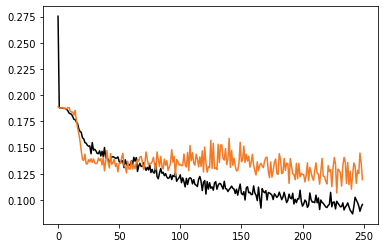

In [12]:
# importing package
import matplotlib.pyplot as plt

# create data
x=list(range(len(train_____)))
  
# plot lines
plt.plot(x, train_____, label = "line 1",color='black')
plt.plot(x, test______, label = "line 2",color='#F47A26')
plt.savefig('myimage.jpg', format='jpg', dpi=1200)

# plt.legend()
plt.show()